In [2]:
import datetime as dat
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

import pecanpy

In [11]:
%matplotlib inline
plt.style.use("ggplot")

In [4]:
# define user credentials
USER_NAME = ???
PASSWORD = ???

# define db server params
SCHEMA = ???
HOST = ???
PORT = ???
DB = ???

# create the engine that connects to the database...
engine = pecanpy.create_engine(USER_NAME, PASSWORD, HOST, PORT, DB)

In [ ]:
# first get a few dataids for households that should have June & December 2016 data
SQLparams = [dat.datetime(2016,6,1,0,0), dat.datetime(2016,12,31,23,59)]
dataIdsSQL = os.getcwd()+os.sep+'generic-querying.sql'
IDs = pecanpy.read_sql_query(engine,SQLfile = dataIdsSQL,params=SQLparams).dataid.tolist()
print('Household IDs: %r'%IDs)

In [ ]:
# now get their hourly data for June & December 2016
SQLparams = [dat.datetime(2016,6,1,0,0), dat.datetime(2016,6,30,23,59),dat.datetime(2016,12,1,0,0), dat.datetime(2016,12,31,23,59)]
SQLparams.extend(IDs)
dataSQL = "SELECT dataid, CAST(localhour AS date) AS datestamp, CAST(EXTRACT(month FROM localhour) AS int) AS month, EXTRACT(hour FROM localhour) AS HR, use FROM commercial.electricity_egauge_hours WHERE ((localhour BETWEEN %s AND %s) or (localhour BETWEEN %s AND %s)) AND dataid IN ("+ ('%s,'*len(IDs))[:-1]+");"
hourly = pecanpy.read_sql_query(engine,SQLstr = dataSQL,params = SQLparams,index_col = ['dataid','month','hr'],parse_dates=['datestamp'])
print('First 10 Records:')
print(hourly.head(10))

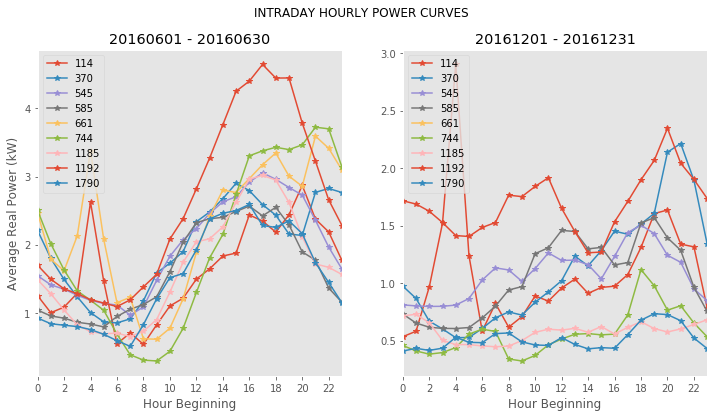

In [26]:
# perform "analysis"
# get the hourly average
havg = hourly.use.groupby(level=[0,1,2]).agg(['mean'])

# now plot the hourly curves
(fh,axpl) = plt.subplots(1,2)
fh.set_size_inches(12,6)
fh.suptitle('INTRADAY HOURLY POWER CURVES')
legs = []
for dataid in havg.index.levels[0]:
    try:
        havg.loc[dataid, 6].plot(ax=axpl[0],kind='line',marker='*') # June
        havg.loc[dataid,12].plot(ax=axpl[1],kind='line',marker='*') # December
    except TypeError:
        pass # not all dataids are guaranteed to have June & Dec, so just ignore a missing set  
    legs.append('%d'%dataid)

plt.sca(axpl[0])    
plt.xlabel("Hour Beginning")
plt.ylabel("Average Real Power (kW)")
plt.xticks([r for r in range(24) if r%2==0])
plt.grid()
plt.legend(legs)
plt.title('%s - %s'%(SQLparams[0].strftime('%Y%m%d'),SQLparams[1].strftime('%Y%m%d')))

plt.sca(axpl[1])    
plt.xlabel("Hour Beginning")
plt.xticks([r for r in range(24) if r%2==0])
plt.grid()
plt.legend(legs)
plt.title('%s - %s'%(SQLparams[2].strftime('%Y%m%d'),SQLparams[3].strftime('%Y%m%d')))